# Phase 1: Hyperparameter Tuning for Machine Learning Model (Random Forest and XGBoost Model) and AUC Evaluation on the Training Dataset

In [89]:
import pandas as pd
import numpy as np
from lifelines import WeibullAFTFitter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.model_selection import GridSearchCV



In [90]:
# CSV file path
file_path = "/Users/suyeonkim/Documents/IAA/Fall 3/Machine Learning/Hw2/insurance_t.csv"

# CSV file load
insurance = pd.read_csv(file_path)
insurance.head()

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,CCPURC,SDB,INCOME,LORES,HMVAL,AGE,CRSCORE,INAREA,INS,BRANCH
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1.0,0,4.0,7.0,87.0,51.0,674.0,1,0,B2
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,0.0,0,30.0,8.5,97.0,60.0,640.0,1,1,B3
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,0.0,0,19.0,3.0,107.0,55.0,662.0,1,1,B7
3,0.8,1,190.03,3,880.25,1,0,1,5.65,NaN,...,NaN,1,20.0,4.0,107.0,40.0,642.0,1,0,B14
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,NaN,...,NaN,0,24.0,8.5,95.0,54.0,732.0,1,0,B15


# EDA and Data Cleaning

In [91]:
unique_counts = insurance.nunique()

# Filter columns with fewer than 10 unique values
binary = unique_counts[unique_counts == 2].index.tolist()
categorical = unique_counts[(unique_counts > 2) & (unique_counts < 10)].index.tolist()
continuous = unique_counts[unique_counts >= 10].index.tolist()

# Display the result
print("Binary:", binary)
print("Categorical:", categorical)
print("Continuous:", continuous)


Binary: ['DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS']
Categorical: ['MMCRED', 'CCPURC']
Continuous: ['ACCTAGE', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'NSFAMT', 'PHONE', 'TELLER', 'SAVBAL', 'ATMAMT', 'POS', 'POSAMT', 'CDBAL', 'IRABAL', 'INVBAL', 'MMBAL', 'CCBAL', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE', 'BRANCH']


In [92]:
#finalize the category
binary = ['DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS']
categorical = ['MMCRED', 'CCPURC', 'BRANCH']
continuous = ['ACCTAGE', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'NSFAMT', 'PHONE', 'TELLER', 'SAVBAL', 'ATMAMT', 'POS', 'POSAMT', 'CDBAL', 'IRABAL', 'INVBAL', 'MMBAL', 'CCBAL', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE']

In [33]:
import pandas as pd

# Check for missing values in binary variables
print(insurance[binary].isna().sum())

# Replace missing values with "M"
insurance[binary] = insurance[binary].apply(lambda x: x.fillna("M"))

# Check for missing values again
print(insurance[binary].isna().sum())


DDA          0
DIRDEP       0
NSF          0
SAV          0
ATM          0
CD           0
IRA          0
INV       1075
MM           0
CC        1075
SDB          0
INAREA       0
INS          0
dtype: int64
DDA       0
DIRDEP    0
NSF       0
SAV       0
ATM       0
CD        0
IRA       0
INV       0
MM        0
CC        0
SDB       0
INAREA    0
INS       0
dtype: int64


In [93]:
# Check for missing values in categorical variables
print(insurance[categorical].isna().sum())

# Replace missing values with "M"
insurance[categorical] = insurance[categorical].apply(lambda x: x.fillna("M"))

# Check for missing values again
print(insurance[categorical].isna().sum())

MMCRED       0
CCPURC    1075
BRANCH       0
dtype: int64
MMCRED    0
CCPURC    0
BRANCH    0
dtype: int64


In [94]:

# Check for missing values in continuous variables
print(insurance[continuous].isna().sum())

# Loop through each continuous variable to add flag columns and impute missing values
for col_name in continuous:
    # Create a flag column to indicate NA values
    flag_column = f"{col_name}_is_imputed"
    insurance[flag_column] = insurance[col_name].isna()
    
    # Calculate the median value and replace NA with the median
    median_value = insurance[col_name].median(skipna=True)
    insurance[col_name].fillna(median_value, inplace=True)

# Check for missing values again
print(insurance[continuous].isna().sum())


ACCTAGE     546
DDABAL        0
DEP           0
DEPAMT        0
CHECKS        0
NSFAMT        0
PHONE      1075
TELLER        0
SAVBAL        0
ATMAMT        0
POS        1075
POSAMT     1075
CDBAL         0
IRABAL        0
INVBAL     1075
MMBAL         0
CCBAL      1075
INCOME     1537
LORES      1537
HMVAL      1537
AGE        1702
CRSCORE     195
dtype: int64
ACCTAGE    0
DDABAL     0
DEP        0
DEPAMT     0
CHECKS     0
NSFAMT     0
PHONE      0
TELLER     0
SAVBAL     0
ATMAMT     0
POS        0
POSAMT     0
CDBAL      0
IRABAL     0
INVBAL     0
MMBAL      0
CCBAL      0
INCOME     0
LORES      0
HMVAL      0
AGE        0
CRSCORE    0
dtype: int64


In [95]:
#check quasi


# Loop through each column in binary_variables
for col in binary:
    # Create a contingency table
    contingency_table = pd.crosstab(insurance[col], insurance['INS'])
    
    # Check if there are any zero values in the contingency table
    if (contingency_table == 0).any().any():
        print(f"\nContingency table for column: {col} contains zero values")
        print(contingency_table)



Contingency table for column: INS contains zero values
INS     0     1
INS            
0    5577     0
1       0  2918


In [96]:
#check quasi


# Loop through each column in categorical variables
for col in categorical:
    # Create a contingency table
    contingency_table = pd.crosstab(insurance[col], insurance['INS'])
    
    # Check if there are any zero values in the contingency table
    if (contingency_table == 0).any().any():
        print(f"\nContingency table for column: {col} contains zero values")
        print(contingency_table)



Contingency table for column: MMCRED contains zero values
INS        0     1
MMCRED            
0       5409  2713
1        130   153
2         33    47
3          4     5
5          1     0


In [97]:
# Convert the MMCRED column to numeric values
insurance['MMCRED_numeric'] = pd.to_numeric(insurance['MMCRED'], errors='coerce')

# Convert MMCRED to strings for modification
insurance['MMCRED_c'] = insurance['MMCRED'].astype(str)

# Update values based on the numeric conversion
insurance.loc[insurance['MMCRED_numeric'] > 2, 'MMCRED_c'] = "3+"

# Convert the updated character column back to category if needed
insurance['MMCRED_c'] = insurance['MMCRED_c'].astype('category')

# Print contingency table
print(pd.crosstab(insurance['MMCRED_c'], insurance['INS']))

# Rename MMCRED_c back to MMCRED
insurance['MMCRED'] = insurance['MMCRED_c']

# Remove MMCRED_c and MMCRED_numeric columns
insurance.drop(['MMCRED_c', 'MMCRED_numeric'], axis=1, inplace=True)


INS          0     1
MMCRED_c            
0         5409  2713
1          130   153
2           33    47
3+           5     5


In [98]:
# Convert all columns to 'category' type except those in the 'continuous' list
for col in insurance.columns:
    if col not in continuous:
        insurance[col] = insurance[col].astype('category')


In [18]:
insurance.columns

Index(['ACCTAGE', 'DDA', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'DIRDEP', 'NSF',
       'NSFAMT', 'PHONE', 'TELLER', 'SAV', 'SAVBAL', 'ATM', 'ATMAMT', 'POS',
       'POSAMT', 'CD', 'CDBAL', 'IRA', 'IRABAL', 'INV', 'INVBAL', 'MM',
       'MMBAL', 'MMCRED', 'CC', 'CCBAL', 'CCPURC', 'SDB', 'INCOME', 'LORES',
       'HMVAL', 'AGE', 'CRSCORE', 'INAREA', 'INS', 'BRANCH',
       'ACCTAGE_is_imputed', 'DDABAL_is_imputed', 'DEP_is_imputed',
       'DEPAMT_is_imputed', 'CHECKS_is_imputed', 'NSFAMT_is_imputed',
       'PHONE_is_imputed', 'TELLER_is_imputed', 'SAVBAL_is_imputed',
       'ATMAMT_is_imputed', 'POS_is_imputed', 'POSAMT_is_imputed',
       'CDBAL_is_imputed', 'IRABAL_is_imputed', 'INVBAL_is_imputed',
       'MMBAL_is_imputed', 'CCBAL_is_imputed', 'INCOME_is_imputed',
       'LORES_is_imputed', 'HMVAL_is_imputed', 'AGE_is_imputed',
       'CRSCORE_is_imputed'],
      dtype='object')

In [99]:
insurance['INS'].describe()

count     8495
unique       2
top          0
freq      5577
Name: INS, dtype: int64

In [101]:
rf = RandomForestClassifier(n_estimators = 500,
                                  random_state = 12345,
                                  oob_score = True)

# Define y as the 'INS' column
y_train = insurance['INS']

# Define X as all columns except 'INS'
X_train = insurance.drop(columns='INS')
# Use one-hot encoding for categorical variables
X_train = pd.get_dummies(X_train)

#label encoding for ordinal


# Fit the Random Forest model
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=500, oob_score=True, random_state=12345)

In [103]:
X_train.head()

,ACCTAGE,DDABAL,DEP,DEPAMT,CHECKS,NSFAMT,PHONE,TELLER,SAVBAL,ATMAMT,...,INCOME_is_imputed_False,INCOME_is_imputed_True,LORES_is_imputed_False,LORES_is_imputed_True,HMVAL_is_imputed_False,HMVAL_is_imputed_True,AGE_is_imputed_False,AGE_is_imputed_True,CRSCORE_is_imputed_False,CRSCORE_is_imputed_True
0,0.7,1986.81,1,446.93,1,0.00,0.0,0,0.00,268.88,...,True,False,True,False,True,False,True,False,True,False
1,4.1,0.00,0,0.00,0,0.00,0.0,0,0.00,0.00,...,True,False,True,False,True,False,True,False,True,False
2,12.3,1069.78,5,6813.58,13,0.00,2.0,9,0.00,0.00,...,True,False,True,False,True,False,True,False,True,False
3,0.8,190.03,3,880.25,1,5.65,0.0,0,11.47,1582.34,...,True,False,True,False,True,False,True,False,True,False
4,1.6,257.13,5,3408.35,14,60.25,0.0,1,9.80,3807.19,...,True,False,True,False,True,False,True,False,True,False


In [104]:
rf.oob_score_

0.7340788699234844

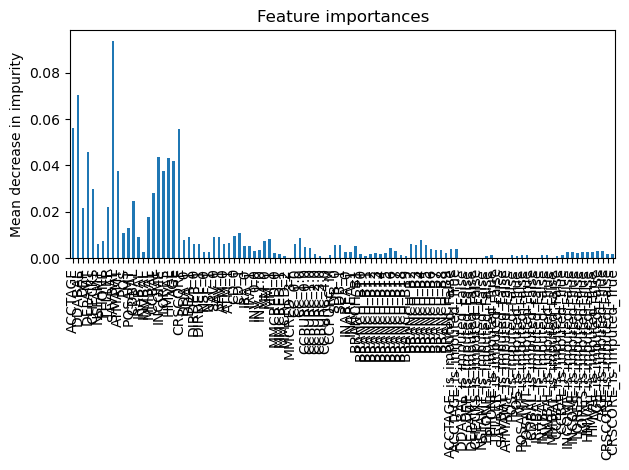

In [105]:
forest_importances = pd.Series(rf.feature_importances_, index = rf.feature_names_in_)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

In [106]:
print(forest_importances)

ACCTAGE                     0.056276
DDABAL                      0.070468
DEP                         0.021861
DEPAMT                      0.045914
CHECKS                      0.030036
                              ...   
HMVAL_is_imputed_True       0.002502
AGE_is_imputed_False        0.003119
AGE_is_imputed_True         0.003120
CRSCORE_is_imputed_False    0.001823
CRSCORE_is_imputed_True     0.001784
Length: 108, dtype: float64


# Tune Parameters of Machine Learning Models in Python (scikit-learn)
- n_estimators: Corresponds to ntree in R, specifying the number of trees in the forest.
- max_features: Similar to mtry, this defines the number of features to consider when looking for the best split. Options include:
'auto': Uses the square root of the total number of features.
'sqrt': Same as 'auto'.
'log2': Uses the base-2 logarithm of the total number of features.
An integer or a float value can also be specified.
- max_depth: Equivalent to setting the depth of the tree, which limits how deep the tree can go. If None, the nodes are expanded until all leaves are pure or contain fewer samples than min_samples_split.
- min_samples_split: The minimum number of samples required to split an internal node. This is similar to nodesize in R.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- max_leaf_nodes: Similar to maxnodes, it specifies the maximum number of leaf nodes in the tree.

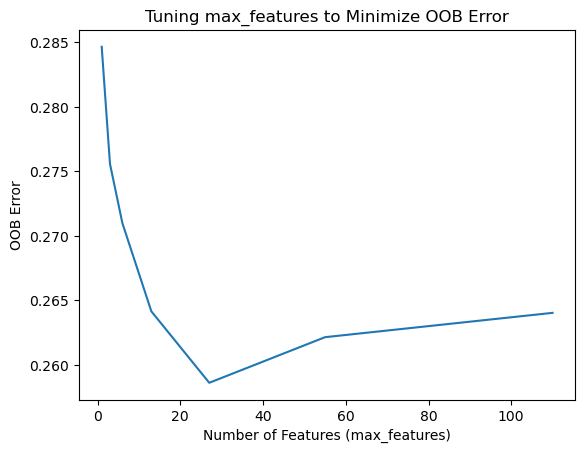

In [43]:

# Set the fixed parameters
n_estimators = 500
step_factor = 0.5
max_features_list = []

# Generate values for max_features to try, based on the step factor
# Start with the total number of features and reduce by step factor
num_features = X_train.shape[1]
current_max_features = num_features

while current_max_features >= 1:
    max_features_list.append(int(current_max_features))
    current_max_features *= step_factor

oob_errors = []

# Loop over different values of max_features
for max_features in max_features_list:
    # Initialize and train the Random Forest model with OOB score enabled
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                               max_features=max_features, 
                               oob_score=True, 
                               random_state=12345)
    rf.fit(X_train, y_train)
    
    # Append the OOB error (1 - OOB score) to the list
    oob_errors.append(1 - rf.oob_score_)

# Plot the OOB error against max_features
plt.plot(max_features_list, oob_errors)
plt.xlabel("Number of Features (max_features)")
plt.ylabel("OOB Error")
plt.title("Tuning max_features to Minimize OOB Error")
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


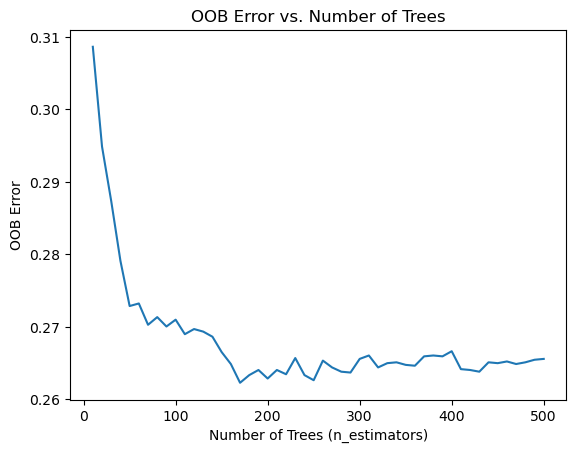

In [44]:

# Set the fixed parameters
max_features = 'sqrt'  # You can choose an appropriate value for max_features
n_estimators_list = np.arange(10, 510, 10)  # Values of n_estimators from 10 to 500 in steps of 10
oob_errors = []

# Loop over different values of n_estimators
for n_estimators in n_estimators_list:
    # Initialize and train the Random Forest model with OOB score enabled
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                               max_features=max_features, 
                               oob_score=True, 
                               random_state=12345)
    rf.fit(X_train, y_train)
    
    # Append the OOB error (1 - OOB score) to the list
    oob_errors.append(1 - rf.oob_score_)

# Plot the OOB error against n_estimators
plt.plot(n_estimators_list, oob_errors)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("OOB Error")
plt.title("OOB Error vs. Number of Trees")
plt.show()


In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_features': [5,6,7,8,9], #starting point = route 49 =7
    'n_estimators': [160, 170, 500]
}

rf = RandomForestClassifier(random_state = 12345)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'bootstrap': [True], 'max_features': [5, 6, 7, 8, 9],
                         'n_estimators': [160, 170, 500]})

In [108]:
grid_search.best_params_

{'bootstrap': True, 'max_features': 7, 'n_estimators': 500}

# Final Random Forest Model
{'bootstrap': True, 'max_features': 7, 'n_estimators': 500}


In [109]:
#final model

rf = RandomForestClassifier(n_estimators = 500,
                                max_features = 7,
                                  random_state = 12345,
                                  oob_score = True)

rf.fit(X_train, y_train)

forest_importances = pd.Series(rf.feature_importances_, index = rf.feature_names_in_)

print(forest_importances)


ACCTAGE                     0.055846
DDABAL                      0.068465
DEP                         0.023347
DEPAMT                      0.045671
CHECKS                      0.030598
                              ...   
HMVAL_is_imputed_True       0.002470
AGE_is_imputed_False        0.003141
AGE_is_imputed_True         0.003129
CRSCORE_is_imputed_False    0.001889
CRSCORE_is_imputed_True     0.001891
Length: 108, dtype: float64


In [48]:
len(insurance)

8495

In [ ]:
#For variable selection, create a random variable to compare with

X_train_r = X_train

X_train_r['random'] = np.random.normal(0, 1, 8495)

rf = RandomForestClassifier(n_estimators = 500,
                                max_features = 7,
                                  random_state = 12345,
                                  oob_score = True)

rf.fit(X_train_r, y_train)



RandomForestClassifier(max_features=7, n_estimators=500, oob_score=True,
                       random_state=12345)

In [111]:
forest_importances = pd.Series(rf.feature_importances_, index = rf.feature_names_in_)
# Convert the Series to a DataFrame
forest_importances_df = forest_importances.sort_values(ascending=False).reset_index()
forest_importances_df.columns = ['Feature', 'Importance']

# Print the DataFrame
print(forest_importances_df)
forest_importances_df.head()



                     Feature  Importance
0                     SAVBAL    0.080876
1                     DDABAL    0.066575
2                     random    0.052502
3                    ACCTAGE    0.050646
4                    CRSCORE    0.050286
..                       ...         ...
104  NSFAMT_is_imputed_False    0.000000
105  CHECKS_is_imputed_False    0.000000
106  DEPAMT_is_imputed_False    0.000000
107     DEP_is_imputed_False    0.000000
108  DDABAL_is_imputed_False    0.000000

[109 rows x 2 columns]


,Feature,Importance
0,SAVBAL,0.080876
1,DDABAL,0.066575
2,random,0.052502
3,ACCTAGE,0.050646
4,CRSCORE,0.050286


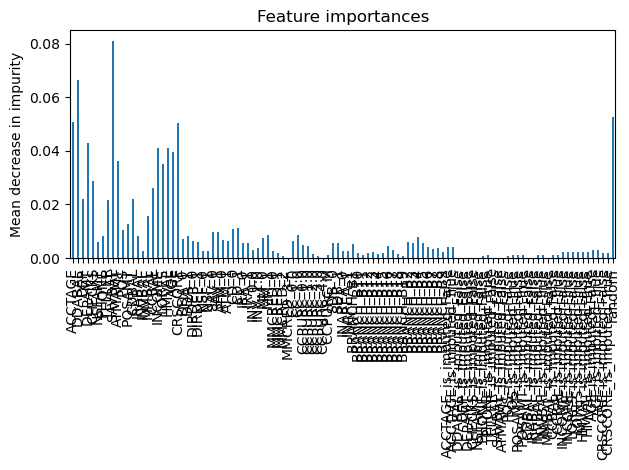

In [112]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()

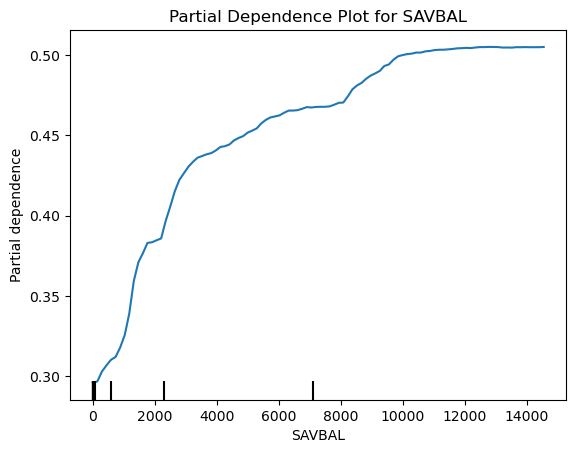

In [114]:
from sklearn.inspection import PartialDependenceDisplay

# Create a partial dependence plot for the feature 'Garage_Area'
PartialDependenceDisplay.from_estimator(
    rf,  # Your fitted Random Forest model
    X_train,  # The training data
    ['SAVBAL'],  # The feature for which to plot partial dependence
    grid_resolution=100  # Number of points on the grid for plotting
)

plt.title("Partial Dependence Plot for SAVBAL")
plt.show()


In [115]:
#final model

rf = RandomForestClassifier(n_estimators = 500,
                                max_features = 7,
                                  random_state = 12345,
                                  oob_score = True)

rf.fit(X_train, y_train)




RandomForestClassifier(max_features=7, n_estimators=500, oob_score=True,
                       random_state=12345)

In [116]:
y_prob

array([0.1125 , 0.73125, 0.65625, ..., 0.225  , 0.75625, 0.2    ])

Area Under the ROC Curve (AUC): 1.0


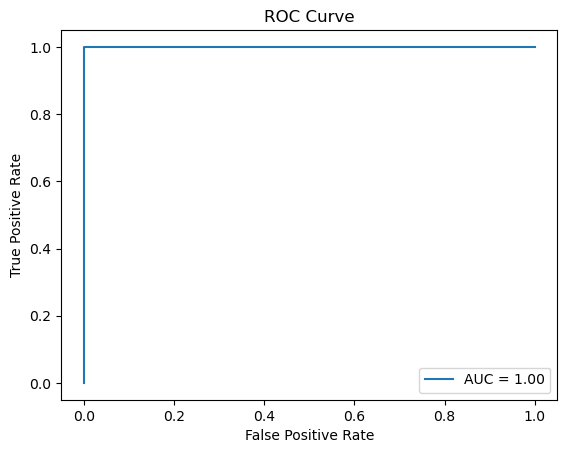

In [ ]:
#Report the area under the ROC curve as well as a plot of the ROC curve on the training dataset.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Predict probabilities for the positive class (usually class 1)
y_prob = rf.predict_proba(X_train)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_train, y_prob)
print("Area Under the ROC Curve (AUC):", auc_score)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_train, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [55]:
#Build an XGBoost Model
from xgboost import XGBClassifier


xgb_insurance = XGBClassifier(n_estimators = 50,
                        subsample = 0.5,
                        random_state = 12345)

xgb_insurance.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=12345, ...)

In [ ]:
#Tune the model parameters and recommend a final XGBoost model.
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'eta': [0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.25, 0.5, 0.75, 1]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 10)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'eta': 0.2, 'max_depth': 4, 'n_estimators': 35, 'subsample': 0.75}

# Final XGBoost Model
{'eta': 0.2, 'max_depth': 4, 'n_estimators': 35, 'subsample': 0.75}

In [118]:
#Final model

xgb_insurance = XGBClassifier(n_estimators = 35,
                        subsample = 0.75,
                        eta = 0.2,
                        max_depth = 4,
                        random_state = 12345)

xgb_insurance.fit(X_train, y_train)



#Variable Selection
import numpy as np

X_train_r = X_train

X_train_r['random'] = np.random.normal(0, 1, 8495)

xgb_insurance = XGBClassifier(n_estimators = 35,
                        subsample = 0.75,
                        eta = 0.2,
                        max_depth = 4,
                        random_state = 12345)

xgb_insurance.fit(X_train_r, y_train)


forest_importances = pd.Series(xgb_insurance.feature_importances_, index = xgb_insurance.feature_names_in_)
# Convert the Series to a DataFrame
forest_importances_df = forest_importances.sort_values(ascending=False).reset_index()
forest_importances_df.columns = ['Feature', 'Importance']

# Print the DataFrame
print(forest_importances_df)

forest_importances_df.head()

       Feature  Importance
0        DDA_0    0.111966
1       SAVBAL    0.102331
2        MMBAL    0.066447
3       DDABAL    0.059513
4        CDBAL    0.043270
..         ...         ...
104       CD_0    0.000000
105  BRANCH_B6    0.000000
106  BRANCH_B7    0.000000
107  BRANCH_B8    0.000000
108   INAREA_0    0.000000

[109 rows x 2 columns]


,Feature,Importance
0,DDA_0,0.111966
1,SAVBAL,0.102331
2,MMBAL,0.066447
3,DDABAL,0.059513
4,CDBAL,0.043270


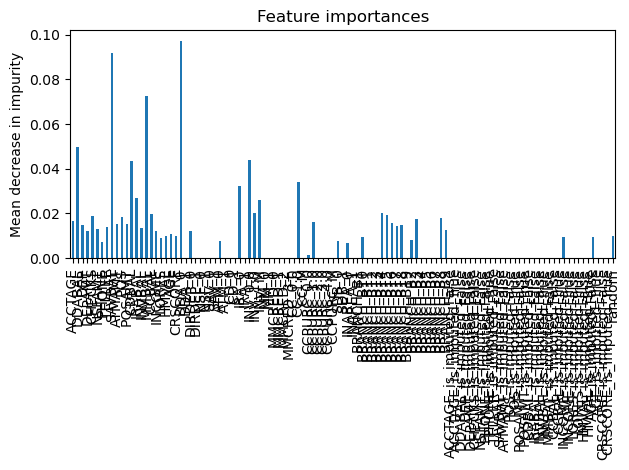

In [59]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.show()


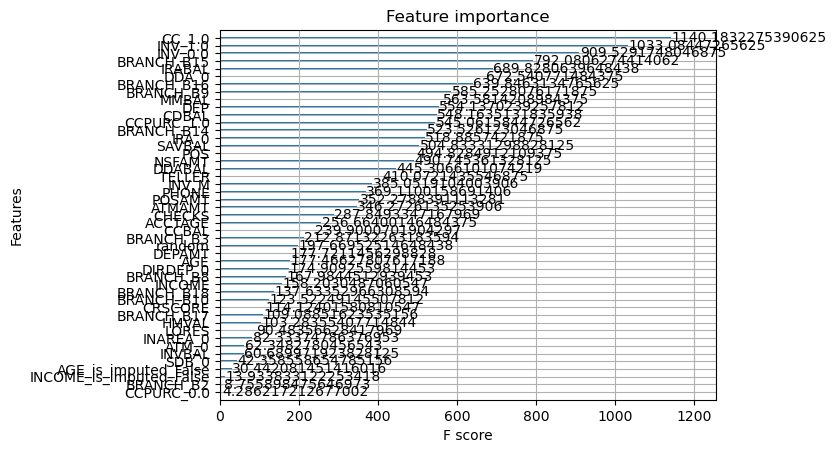

In [60]:
#another way to plot
import xgboost

xgboost.plot_importance(xgb_insurance, importance_type = 'cover')

plt.show()

Area Under the ROC Curve (AUC): 0.8522657067366298


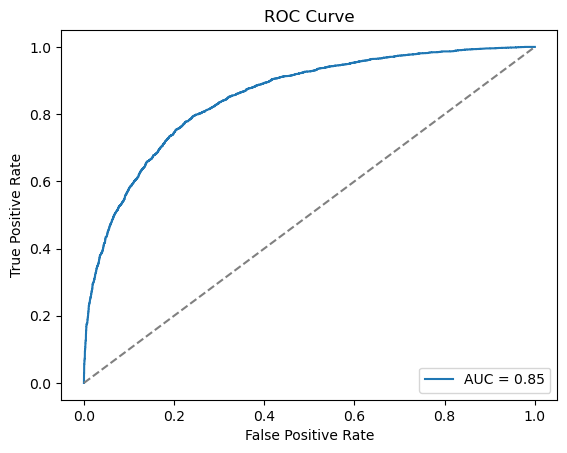

In [119]:
#AUC
# Predict the probabilities for the positive class (usually class 1)
y_prob = xgb_insurance.predict_proba(X_train)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_train, y_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_train, y_prob)
print("Area Under the ROC Curve (AUC):", auc_score)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
